In [2]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = 'cpu'

%load_ext autoreload
%autoreload 2

In [174]:
from sklearn.linear_model import LassoCV

In [238]:
data = loadmat('Diffusion_2D_space41.mat')
data = np.real(data['Expression1']).reshape((41,41,41,4))[:,:,:,3]
down_data= np.take(np.take(np.take(data,np.arange(0,data.shape[0],1),axis=0),np.arange(0,data.shape[1],1),axis=1),np.arange(0,data.shape[2],9),axis=2)

print("Dowmsampled shape:",down_data.shape)

Dowmsampled shape: (41, 41, 5)


In [239]:
width, width_2, steps = down_data.shape
x_arr = np.linspace(0,1,width)
y_arr = np.linspace(0,1,width_2)
t_arr = np.linspace(0,1,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')

In [240]:
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = np.float32(down_data.reshape((down_data.size, 1)))

We select the noise level we add to the data-set

In [241]:
noise_level = 0.01


In [242]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

In [243]:
solution = y_noisy.reshape(down_data.shape)

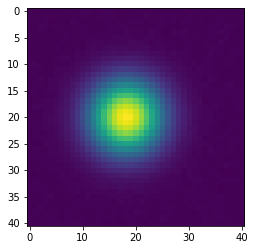

In [244]:
plt.imshow(solution[:,:,1])

Select the number of samples:

In [245]:
steps = down_data.shape[2]
dim_w = 3
denoised_sol = []
for i in np.arange(steps):
    uwn,sigmawn,vwn= np.linalg.svd(solution[:,:,i])
    vwn = vwn.T
    denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
denoised_sol = np.transpose(np.array(denoised_sol),(1,2,0))

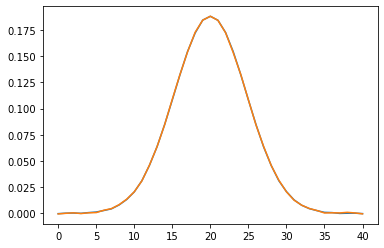

In [246]:
plt.plot(denoised_sol[:,20,1])
plt.plot(solution[:,20,1])

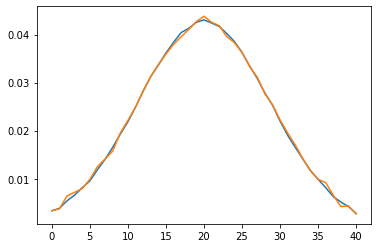

In [247]:
plt.plot(denoised_sol[:,20,4])
plt.plot(solution[:,20,4])

In [248]:
bor = 1
u = denoised_sol[:,:,:][bor:-bor,bor:-bor,:]
u_t = finite_diff(denoised_sol[:,:,:],t_arr,order=1,axis=2)[bor:-bor,bor:-bor,:]
u_x = finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0)[bor:-bor,bor:-bor,:]
u_xx = finite_diff(denoised_sol[:,:,:],x_arr,order=2,axis=0)[bor:-bor,bor:-bor,:]
u_y = finite_diff(denoised_sol[:,:,:],y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]
u_yy = finite_diff(denoised_sol[:,:,:],y_arr,order=2,axis=1)[bor:-bor,bor:-bor,:]
u_xy = finite_diff(finite_diff(denoised_sol[:,:,:],x_arr,order=1,axis=0),y_arr,order=1,axis=1)[bor:-bor,bor:-bor,:]

In [249]:
X = np.transpose((t_grid[bor:-bor,bor:-bor,:].flatten(), x_grid[bor:-bor,bor:-bor,:].flatten(), y_grid[bor:-bor,bor:-bor,:].flatten()))
library = np.float32((np.ones_like(u).flatten(),u.flatten(), u_x.flatten(), u_y.flatten(),u_xx.flatten(),u_yy.flatten(),u_xy.flatten())).T
u_t = u_t.reshape((-1, 1))

In [250]:
np.linalg.lstsq(library, u_t)[0]

<ipython-input-250-457ca3085e09>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(library, u_t)[0]


array([[ 1.94310022e-02],
       [-1.13667577e+00],
       [-4.92535122e-05],
       [ 2.59133375e-02],
       [ 1.16411414e-03],
       [ 1.16130653e-03],
       [ 1.51641036e-08]])

In [251]:
reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(library, u_t).coef_[:, None])# %%

[[-0.        ]
 [-0.        ]
 [-0.        ]
 [ 0.        ]
 [ 0.00285564]
 [ 0.00285259]
 [ 0.        ]]


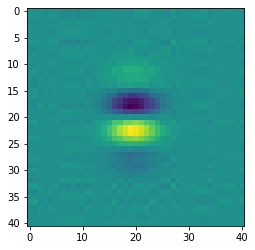

In [199]:
plt.imshow(finite_diff(denoised_sol[:,:,3],x_arr,order=3,axis=0))

In [48]:
y_arr.shape

(41,)

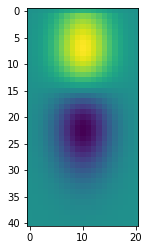

In [57]:
plt.imshow(finite_diff(down_data[:,:,3].T,y_arr,order=1))

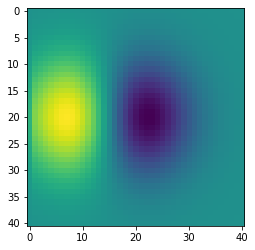

In [32]:
plt.imshow(finite_diff(down_data[:,:,3].T,y_arr,order=1).T)

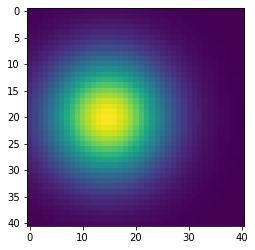

In [20]:
plt.imshow(down_data[:,:,3])

In [ ]:
def spline_diff2D(z, x, y, order, **spline_kwargs):
    ''' Fits 2D spline to 2D data. x and y are 1D arrays of coordinate grid, z is 2D array with dara.
    Good defaults for spline would be kx=4, ky=4, s=1e-2 with noise, 0.0 if no noise.'''
    spline = RectBivariateSpline(x, y, z, **spline_kwargs)
    return spline(x, y, dx=order, dy=order)
# Example usage
u_approx_spline = spline_diff2D(u_true, t, x, order=0, kx=4, ky=4, s=0.0) # approximation of data
u_approx_spline = spline_diff2D(u_true, t, x, order=3, kx=4, ky=4, s=0.0) # 3rd order deriv

In [ ]:

# %% Checking finite diff
dt, theta = library(u_true, x, t, deriv_kind='fd')
print(np.linalg.lstsq(theta, dt)[0]) # normal lst sq.
print(np.linalg.lstsq(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1))[0]) # lst sq. with edges cut off

reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(theta, dt).coef_[:, None])# %%
print(reg.fit(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1)).coef_[:, None])# %%

# %% Checking spline 
dt, theta = library(u_true, x, t, deriv_kind='spline', s=0.0, k=5) #s=0.0 is necessary for decent spline fit
print(np.linalg.lstsq(theta, dt)[0]) # normal lst sq.
print(np.linalg.lstsq(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1))[0]) # lst sq. with edges cut off

reg = LassoCV(fit_intercept=False, cv=10)
print(reg.fit(theta, dt).coef_[:, None])# %%
print(reg.fit(theta.reshape(50, 100, 12)[2:-2, 3:-3, :].reshape(-1, 12), dt.reshape(50, 100)[2:-2, 3:-3].reshape(-1, 1)).coef_[:, None])# %%